# <center> <font style="color:rgb(100,109,254)">Real Time Object Detection with Image Features  </font> </center>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## <font style="color:rgb(134,19,348)"> Feature Matching + Homography to find Objects.   </font>

We have learned how to match descriptors of two images and then check the number of matches to determine if the object is present in the image or not. Similarly we can take this one step further and even get the coordinates of the object in another image Via Homography. Since in Homography you estimate the transformation of an image (in this case an object) by working with the transformed points. In our *Geometric Transformations Notebook* we have already learned how to get the 3x3 homography matrix using the function **cv2.getPerspectiveTransform()** and then used to warp the image with **cv2.warpPerspective()** but this time we will be using a more robust approach primarily because last time our points were selected by us but this time they will approximated by feature detection algorithm, so there will possibly be outliers.

You're already familiar with these outliers as you have seen there are almost always mis-matches, and these can effect the results. So in our implementation we will be using **cv2.findHomography()** to find the homography matrix and then **cv2.perspectiveTransform()** *(This applies perspective transform on a vector instead of an image.)* to  find the object.

### <font style="color:rgb(134,19,348)"> Finding Homography    </font>


[```	Matrix, mask = cv2.findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]]) ```](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780)

**Params:**

- **srcPoints**	Coordinates of the points in the original plane, a matrix of the type CV_32FC2 or vector<Point2f> .
- **dstPoints**	Coordinates of the points in the target plane, a matrix of the type CV_32FC2 or a vector<Point2f> .
- **method**	Method used to compute a homography matrix. The following methods are possible:
    1.  **`0`** - a regular method using all the points, i.e., the least squares method
    2. **`RANSAC`** - RANSAC-based robust method
    3. **`LMEDS`** - Least-Median robust method
    4. **`RHO`** - PROSAC-based robust method


- **ransacReprojThreshold**	Maximum allowed reprojection error to treat a point pair as an inlier (used in the RANSAC and RHO methods only). That is, if: <br>
          `  ∥dstPointsi−convertPointsHomogeneous(H∗srcPointsi)∥2>ransacReprojThreshold`
then the point i is considered as an outlier. If srcPoints and dstPoints are measured in pixels, it usually makes sense to set this parameter somewhere in the range of 1 to 10.
- **mask**	Optional output mask set by a robust method ( RANSAC or LMEDS ). Note that the input mask values are ignored.
- **maxIters**	The maximum number of RANSAC iterations.
- **confidence**	Confidence level, between 0 and 1.

<br>

### <font style="color:rgb(134,19,348)"> Perspective Transformation   </font>

```dst = cv2.perspectiveTransform(src, m[, dst] )```

**Params:**


- **`src`**	input two-channel or three-channel floating-point array; each element is a 2D/3D vector to be transformed.
- **`dst`**	output array of the same size and type as src.
- **`m`**	3x3 or 4x4 floating-point transformation matrix.


### <font style="color:rgb(134,19,348)">  Note:  </font>
Again both methods **getPerspectiveTransform()** and **cv2.findHomography()** will find the perspective transformation between two sets of points and here is the difference between the two.

**getPerspectiveTransform()**  is useful in many situations where you only have 4 points, and you are sure they are the correct ones (e.g you yourself marked those points). The **findHomography()** is usually used when you're trying to detect the points with some automatic method (like feature detection), in this scenario you will have lots of points with low confidence, and so inside the **findHomography()** you will use an algorithm called **RANSAC** or **LEAST_MEDIAN**, these algorithms will separate 
inlier points with the outlier points.

So good matches which provide correct estimation of object are called inliers and remaining are called outliers. **cv2.findHomography()** returns a mask which specifies the inlier and outlier points.

**RANSAC (Random Model Consensus):** <br>
Its a powerful model fitting algorithms that can handles a large number of outliers.

## <font style="color:rgb(134,19,348)">   Feature Matching + Detection With ORB  </font>
First lets detect features and match descriptors to get some good matches.

In [162]:
img1 = cv2.imread('media/M4/chemcropped.jpg',1)  # queryImage
img2 = cv2.imread('media/M4/samplechem.jpg',1) # trainImage

# Initialize ORB detector
orb = cv2.ORB_create(4000,fastThreshold=30)

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

index_params= dict(algorithm = 6, table_number = 6, key_size = 12, multi_probe_level = 1)

search_params = dict(checks=100)   

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good_points = []
for m,n in matches:
    if m.distance < 0.60*n.distance:
        good_points.append(m)

**Now if enough good matches are found we are going to proceed with computing homography and extracting the perspective transformation.**

In [163]:
# min number of matches to call it a match.
MIN_MATCH_COUNT = 10

# Check if there are enough matches to detrmine if the object is actually present in the trainImg.
if len(good_points) > MIN_MATCH_COUNT: 
    
    # We are grabbing the locations of all the good matched points from both the images and formating them in a list
    src_pts = []
    dst_pts = []
    
    # Remember the indexes (e.g m.queryIdx) are the indexes of only the good matches in all the matches.
    for m in good_points:
        # This will be a tuple of x,y coordinate of a good match
        src_pts.append( kp1[m.queryIdx].pt )
        dst_pts.append( kp2[m.trainIdx].pt )
        
    # Converting to Float and Reshaping from shape (no_of_matches, 2) to (no_of_matches, 1, 2)    
    src_pts = np.float32(src_pts).reshape(-1, 1, 2) 
    dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

    # A 3x3 homography transformation matrix is obtained
    M , _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
       
    # Extracting the height and width of the Query Image.    
    h,w = img1.shape[:2]
    
    # This is the full size of our original Query Image.
    pts = np.float32([[0,0],[0,h],[w,h],[w,0] ]).reshape(-1,1,2)  
    
    # Takes in the initial points and transformation matrix and returns an array of same size as pts.
    # If your object is a rectangle then points in this array is just your usual 4 boundary points of that object.
    dst = cv2.perspectiveTransform(pts, M)
    
    # Drawing a polygon on the detected Object. We are not drawing a rectangle since your object may be rotated at an angle.
    final_image = cv2.polylines(img2.copy(), [np.int32(dst)], True, (255,0,0), 3, cv2.LINE_AA)
  
else:
    print("Not enough matches are found " + len(good))

**Finally you can draw the detected Object**

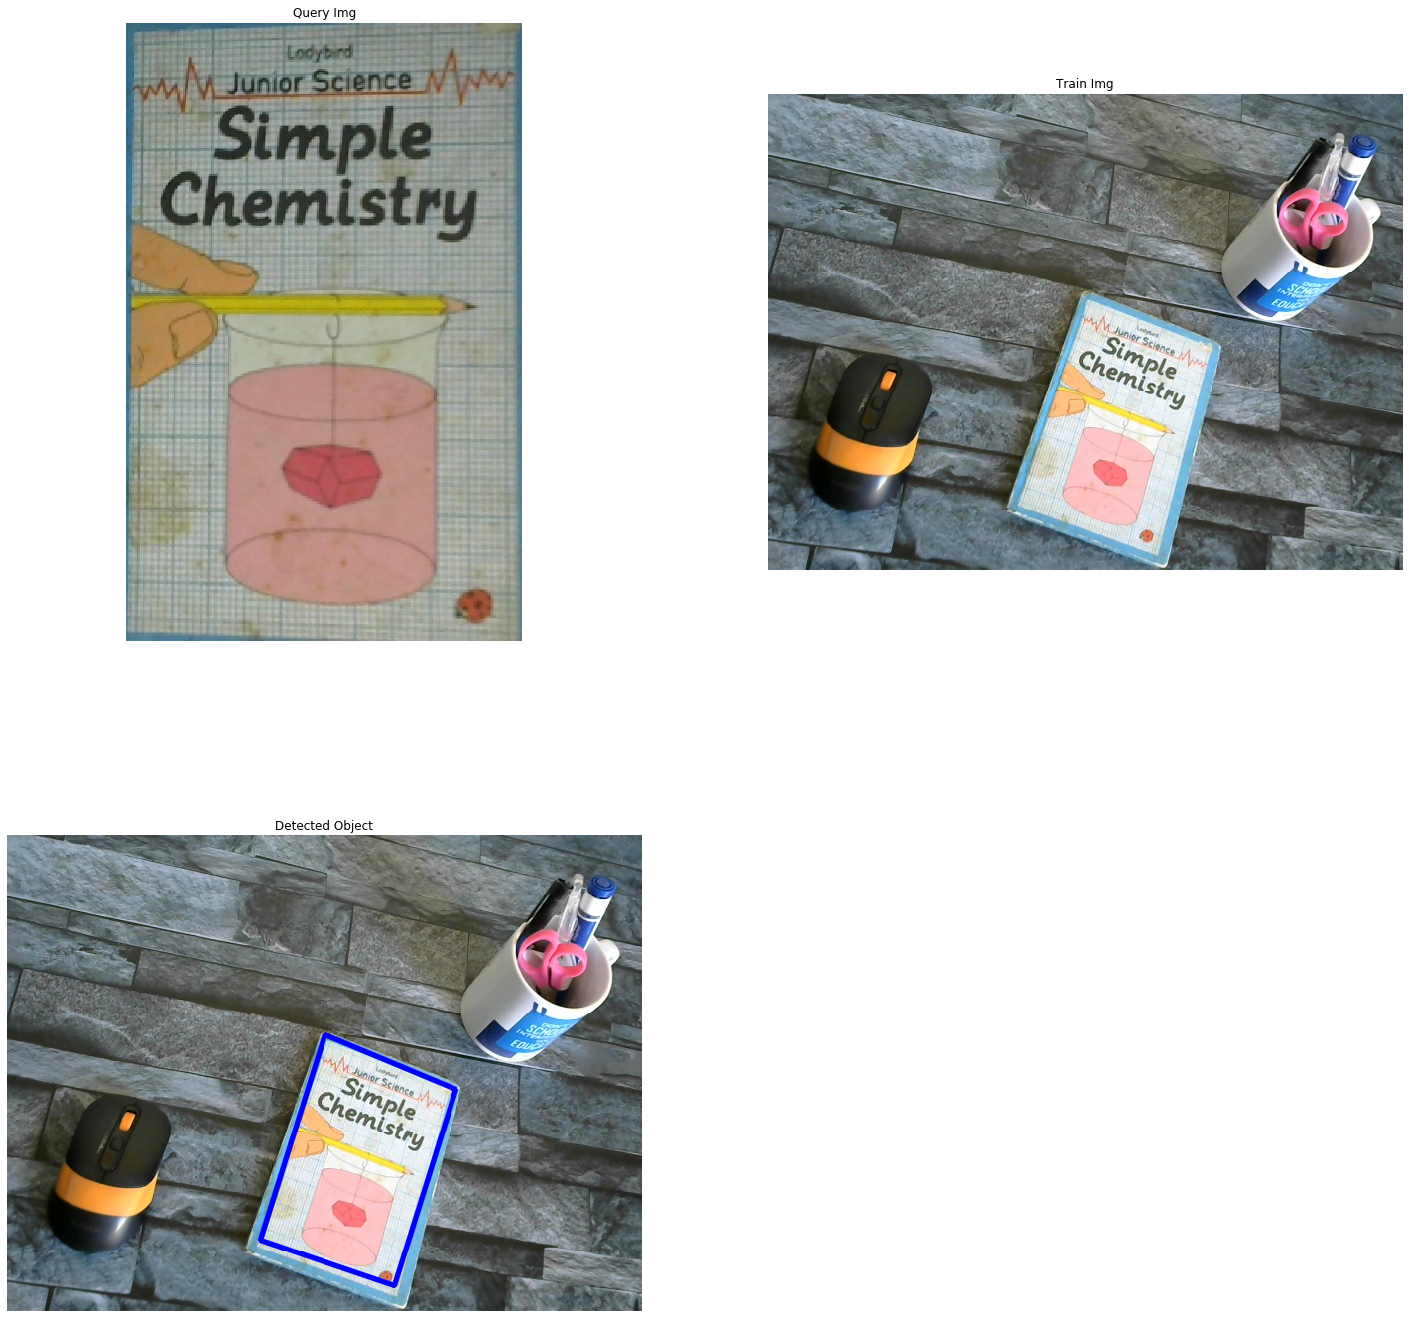

In [168]:
plt.figure(figsize=[25,25])
plt.subplot(221);plt.imshow(img1[...,::-1]);plt.title("Query Img");plt.axis('off');
plt.subplot(222);plt.imshow(img2[...,::-1]);plt.title("Train Img");plt.axis('off');
plt.subplot(223);plt.imshow(final_image[...,::-1]);plt.title("Detected Object");plt.axis('off');

## <font style="color:rgb(134,19,348)">  Real Time Object Detection with Orb  </font>
Here we will take the code above and apply it in a real time application.

In [159]:
# Using the required driver for full resolution display
cap = cv2.VideoCapture(1,cv2.CAP_DSHOW)

# Using the full resolution of my webcam.
cap.set(3,1280)
cap.set(4,960)

orb = cv2.ORB_create(4000, fastThreshold=30)

img = cv2.imread('media/M4/chemcropped.jpg',0)
kp1, desc1 = orb.detectAndCompute(img, None)

FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6,  key_size = 12,  multi_probe_level = 1)

search_params = dict(checks=100)  
flann = cv2.FlannBasedMatcher(index_params,search_params)

cv2.namedWindow('Homography', cv2.WINDOW_NORMAL)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame,1)
        
    kp2, desc2 = orb.detectAndCompute(frame, None)
    matches = flann.knnMatch(desc1, desc2, k=2)

    try:
        good_points = []
        for m, n in matches:
            if m.distance <0.67* n.distance:
                good_points.append(m) 

    except Exception as e:
        if e == 'not enough values to unpack (expected 2, got 1)':
            cv2.imshow("Homography", frame)

    if len(good_points) > 8:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)

        matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h, w = img.shape[:2]
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, matrix)

        homography = cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 0), 3)

        cv2.imshow("Homography", homography)
    else:
        cv2.imshow("Homography", frame)

        
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
 
cap.release()
cv2.destroyAllWindows()

###  <font style="color:rgb(34,169,134)"> Assignment: Feature based Object Detector </font>
Now your task is to create your own Object detector on something other than a book, It should be a planer surface with high texture for reasonable accuracy.

In [160]:
### ADD CODE HERE